###Импорты

In [76]:
%matplotlib inline

import json
import math

import numpy
import matplotlib.pyplot as plot
import pandas

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.grid_search import GridSearchCV

### Лемматизатор

In [2]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import string
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

###Функция для F1 меры

In [3]:
def f1_measure(P,R):
    return [2*x*y/(x+y) for x,y in zip(P, R)]

###Relevance Frequency

In [4]:
def get_after_rf_matrix(in_matrix, target, out_n_features, test_X):
    def bin_f(x):
        return 1 if x > 0 else 0
    n_vec = numpy.vectorize(bin_f)
    in_matrix_bin = n_vec(in_matrix)
    target = numpy.array(target)
    posit_pos = numpy.where(target == 1)[0]
    posit_neg = numpy.where(target == 0)[0]
    pos_rf_prepare = in_matrix_bin[posit_pos].sum(axis=0) 
    neg_rf_prepare = in_matrix_bin[posit_neg].sum(axis=0)
    pos_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(pos_rf_prepare, neg_rf_prepare)])
    neg_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(neg_rf_prepare, pos_rf_prepare)])
    l_pos = pos_rf.argsort()[-out_n_features//2:]
    l_neg = neg_rf.argsort()[-out_n_features//2:]
    return ((in_matrix.transpose()[list(set(l_pos) | set(l_neg))]).transpose(),
            (test_X.transpose()[list(set(l_pos) | set(l_neg))]).transpose())

###Кросс-валидация

In [5]:
def cross_valid(matrix_counts, target, test_size=0.3, random_state=0):
    X_train, X_test, Y_train, Y_test = train_test_split(matrix_counts, target, test_size=0.3, random_state=0)
    return (X_train, X_test, Y_train, Y_test)

###Функции для рисования Recall-Precision и ROC кривой

In [6]:
def rp_curve(title, Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:,1])
    plot.plot(recall, precision, label='R-P '+label);
    plot.plot(recall, f1_measure(precision, recall), label='F1 '+label)
    plot.xlabel('Recall'); plot.ylabel('Precision'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);

def rp_no_proba_curve(title, Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:])
    plot.plot(recall, precision, label='R-P '+label);
    plot.plot(recall, f1_measure(precision, recall), label='F1 '+label)
    plot.xlabel('Recall'); plot.ylabel('Precision'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    
def roc_curve(title, Y_test, predicted, label='?'):
    fpr, tpr, th = metrics.roc_curve(Y_test, predicted[:,1])
    plot.plot(fpr, tpr, label=label);
    plot.xlabel('False Positive'); plot.ylabel('True Positive'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    print 'Logistic Regression (', label, ') AUC = ', metrics.auc(fpr, tpr)   
    
def roc_no_proba_curve(title, Y_test, predicted, label='?'):
    fpr, tpr, _ = metrics.roc_curve(Y_test, predicted[:])
    plot.plot(fpr, tpr, label=label);
    plot.xlabel('False Positive'); plot.ylabel('True Positive'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    print 'Logistic Regression (', label, ') AUC = ', metrics.auc(fpr, tpr)

###Логистическая регрессия

In [35]:
def logistic_reg(X_train, X_test, Y_train, **kwargs):
    model_logistic = LogisticRegression(**kwargs)
    model_logistic.fit(X_train, Y_train)
    predicted = model_logistic.predict_proba(X_test)
    return predicted, model_logistic

###Random Forest Classifier

In [8]:
def random_forest_reg(X_train, X_test, Y_train, **kwargs):
    model_rfc = RandomForestClassifier(**kwargs)
    model_rfc.fit(X_train, Y_train)
    predicted = model_rfc.predict_proba(X_test)
    return predicted

###SVM

In [9]:
def svm_cl(X_train, X_test, Y_train, **kwargs):
    clf = svm.SVC(probability=True, **kwargs)
    clf.fit(X_train, Y_train)
    predicted = clf.predict_proba(X_test)
    return predicted

------

###Чтение файлов, bag of words, множество ответов

In [10]:
with open('pos_reviews.json') as data_file:    
    data_pos = json.load(data_file)
with open('neg_reviews.json') as data_file:    
    data_neg = json.load(data_file)

pos_texts = data_pos.keys()
neg_texts = data_neg.keys()
all_texts = pos_texts + neg_texts

N_POS_TEXTS = len(pos_texts)
N_NEG_TEXTS = len(neg_texts)
target = [1]*N_POS_TEXTS + [0]*N_NEG_TEXTS

###Матрица частотности

In [71]:
count_vect = CountVectorizer()
temp_matrix = count_vect.fit_transform(all_texts)
matrix_counts = temp_matrix.toarray()

N_FEATURES = matrix_counts.shape[1]
words_as_features = {count_vect.vocabulary_.get(x):x for x in count_vect.vocabulary_}

In [29]:
def log_f(x):
    return math.log(x+1)
n_vec_log_f = numpy.vectorize(log_f)
matrix_counts_log = n_vec_log_f(matrix_counts)

####без стоп слов

In [12]:
count_vect_without_stopwords = CountVectorizer(stop_words='english')
matrix_counts_without_stopwords = count_vect_without_stopwords.fit_transform(all_texts).toarray()

####с лемматизатором

In [13]:
count_vect_with_lemm = CountVectorizer(tokenizer=tokenize)
matrix_counts_with_lemm = count_vect_with_lemm.fit_transform(all_texts).toarray()

####без стопслов с лемматизатором

In [14]:
count_vect_with_lemm_without_stopwords = CountVectorizer(stop_words='english', tokenizer=tokenize)
matrix_counts_with_lemm_without_stopwords = count_vect_with_lemm_without_stopwords.fit_transform(all_texts).toarray()

###Бинарная матрица встречаемости

In [15]:
count_vect_bin = CountVectorizer(binary=True)
matrix_counts_bin = count_vect_bin.fit_transform(all_texts).toarray()

###TF-IDF матрица

In [16]:
tfidf_transformer = TfidfTransformer()
matrix_tfidf = tfidf_transformer.fit_transform(temp_matrix).toarray()

----

###Сравнение логистической регрессии (L1 & L2)

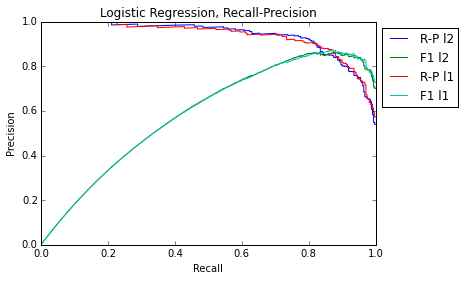

Logistic Regression ( l2 ) AUC =  0.931306706992
Logistic Regression ( l1 ) AUC =  0.932451965842

TOP 10 pos
fun, importance = 0.58220
great, importance = 0.43094
american, importance = 0.36546
well, importance = 0.36121
memorable, importance = 0.35830
jackie, importance = 0.31934
excellent, importance = 0.31870
solid, importance = 0.31402
job, importance = 0.31284
mulan, importance = 0.30724

TOP 10 neg
bad, importance = -0.69696
unfortunately, importance = -0.56733
worst, importance = -0.55011
nothing, importance = -0.44924
plot, importance = -0.41437
only, importance = -0.40243
poor, importance = -0.39973
script, importance = -0.39759
boring, importance = -0.35820
awful, importance = -0.35088


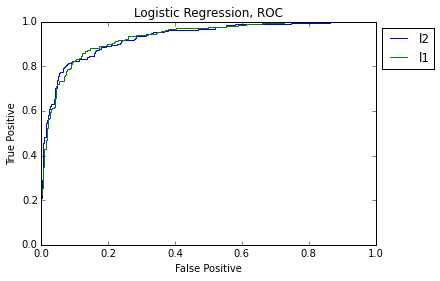

In [82]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
logreg_counts_l2_predicted, log_counts_model = logistic_reg(X_train, X_test, Y_train)
logreg_counts_l1_predicted, _ = logistic_reg(X_train, X_test, Y_train, penalty='l1', C=1000)

rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_counts_l2_predicted, label='l2')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_counts_l1_predicted, label='l1')
plot.show()
roc_curve('Logistic Regression, ROC', Y_test, logreg_counts_l2_predicted, label='l2')
roc_curve('Logistic Regression, ROC', Y_test, logreg_counts_l1_predicted, label='l1')

print '\n', 'TOP 10 pos'
for idx in numpy.argsort(log_counts_model.coef_)[0][::-1][:10]: # последние 10 с максимальным коэфициентом
    print '{}, importance = {:.5f}'.format(words_as_features.get(idx), log_counts_model.coef_[0][idx])
print '\n', 'TOP 10 neg'
for idx in numpy.argsort(log_counts_model.coef_)[0][:10]: # последние 10 с минимальным коэфициентом
    print '{}, importance = {:.5f}'.format(words_as_features.get(idx), log_counts_model.coef_[0][idx])

###Логистическая регрессия на бинарной матрице встречаймости

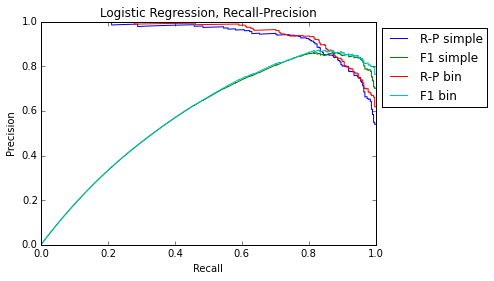

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( bin ) AUC =  0.943237413272


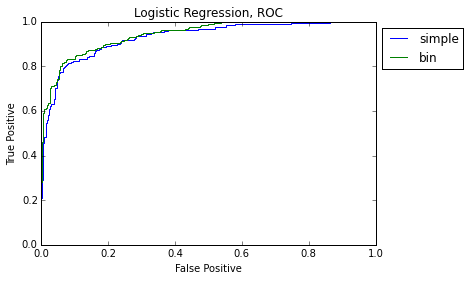

In [18]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_bin, target)
logreg_bin_predicted = logistic_reg(X_train, X_test, Y_train)
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_bin_predicted, label='bin')
plot.show()
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_bin_predicted, label='bin')

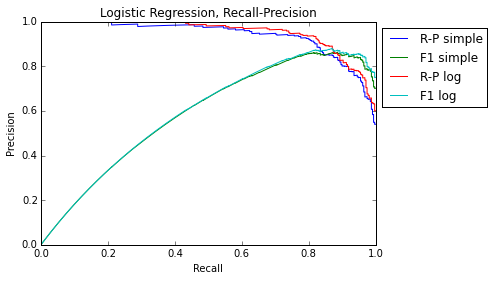

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( log ) AUC =  0.945194360434


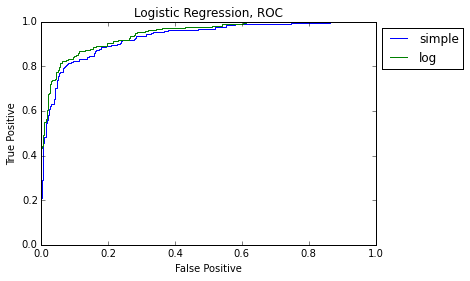

In [30]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_log, target)
logreg_log_predicted = logistic_reg(X_train, X_test, Y_train)
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_log_predicted, label='log')
plot.show()
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_log_predicted, label='log')

###сравнение RF и простой логистической регрессией 

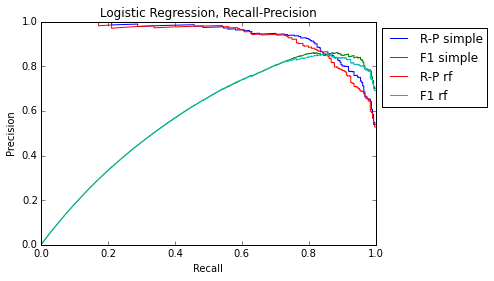

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( rf ) AUC =  0.920977139299


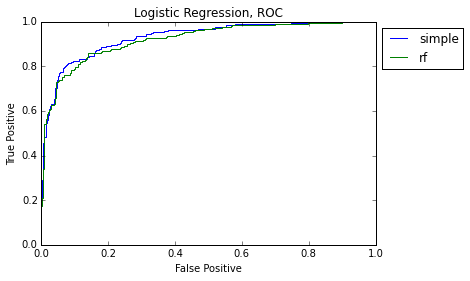

In [19]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
X_train_rf, X_test_rf = get_after_rf_matrix(X_train, Y_train, 35000, X_test)
logreg_3_predicted = logistic_reg(X_train_rf, X_test_rf, Y_train)

rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_3_predicted, label='rf')
plot.show()
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_3_predicted, label='rf')

###Логистическая регрессия TF-IDF

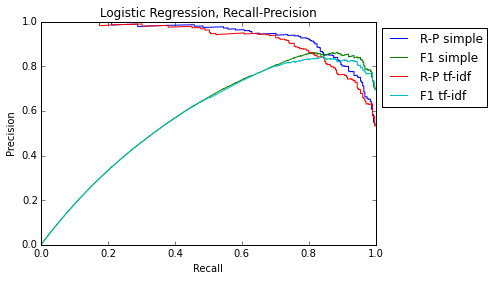

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( tf-idf ) AUC =  0.91363858744


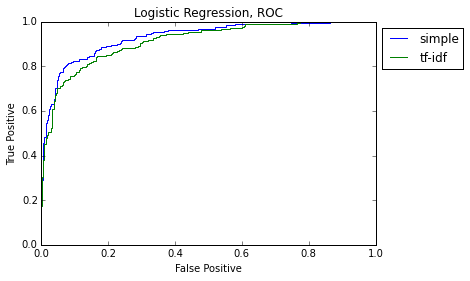

In [20]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_tfidf, target)
logreg_4_predicted = logistic_reg(X_train, X_test, Y_train)
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_4_predicted, label='tf-idf')
plot.show()
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_4_predicted, label='tf-idf')

### Проверка гипотез о удалении стопслов и лемматизации

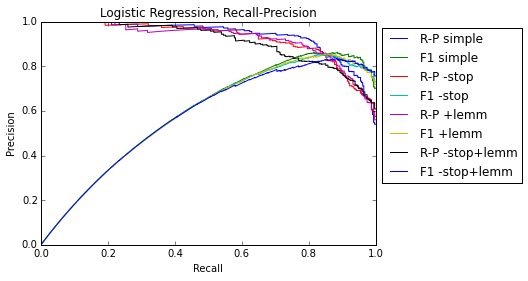

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( -stop ) AUC =  0.917152197118
Logistic Regression ( +lemm ) AUC =  0.917841576232
Logistic Regression ( -stop+lemm ) AUC =  0.905010229497


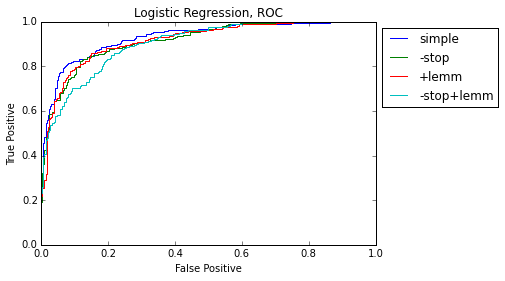

In [21]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_without_stopwords, target)
logreg_5_predicted = logistic_reg(X_train, X_test, Y_train)

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_with_lemm, target)
logreg_6_predicted = logistic_reg(X_train, X_test, Y_train)

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_with_lemm_without_stopwords, target)
logreg_7_predicted = logistic_reg(X_train, X_test, Y_train)

rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_5_predicted, label='-stop')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_6_predicted, label='+lemm')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_7_predicted, label='-stop+lemm')
plot.show()
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_5_predicted, label='-stop')
roc_curve('Logistic Regression, ROC', Y_test, logreg_6_predicted, label='+lemm')
roc_curve('Logistic Regression, ROC', Y_test, logreg_7_predicted, label='-stop+lemm')

### Сравнение логистической регрессии и random-forest

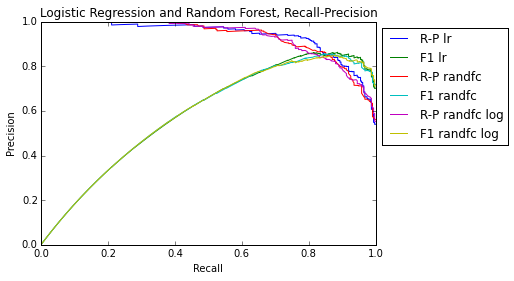

Logistic Regression ( lr ) AUC =  0.931306706992
Logistic Regression ( randfc ) AUC =  0.923578989504
Logistic Regression ( randfc log ) AUC =  0.924001512186


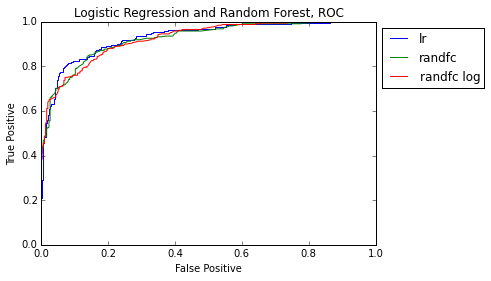

In [34]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
random_forest_count_predicted = random_forest_reg(X_train, X_test, Y_train, n_estimators=1000)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_log, target)
random_forest_count_log_predicted = random_forest_reg(X_train, X_test, Y_train, n_estimators=1000)

rp_curve('Logistic Regression and Random Forest, Recall-Precision', Y_test, logreg_1_predicted, label='lr')
rp_curve('Logistic Regression and Random Forest, Recall-Precision', Y_test, random_forest_count_predicted, label='randfc')
rp_curve('Logistic Regression and Random Forest, Recall-Precision', Y_test, random_forest_count_log_predicted, label='randfc log')
plot.show()
roc_curve('Logistic Regression and Random Forest, ROC', Y_test, logreg_1_predicted, label='lr')
roc_curve('Logistic Regression and Random Forest, ROC', Y_test, random_forest_count_predicted, label='randfc')
roc_curve('Logistic Regression and Random Forest, ROC', Y_test, random_forest_count_log_predicted, label='randfc log')

### Сравнение логистической регрессии и SVM

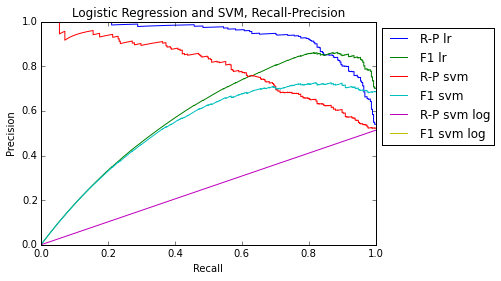

Logistic Regression ( lr ) AUC =  0.931306706992
Logistic Regression ( svm ) AUC =  0.773016367194
Logistic Regression ( svm log ) AUC =  0.493150684932


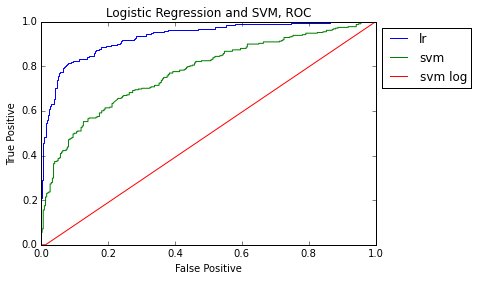

In [32]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
svm_count_predicted = svm_cl(X_train, X_test, Y_train)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_log, target)
svm_count_log_predicted = svm_cl(X_train, X_test, Y_train)

rp_curve('Logistic Regression and SVM, Recall-Precision', Y_test, logreg_1_predicted, label='lr')
rp_curve('Logistic Regression and SVM, Recall-Precision', Y_test, svm_count_predicted, label='svm')
rp_curve('Logistic Regression and SVM, Recall-Precision', Y_test, svm_count_log_predicted, label='svm log')
plot.show()
roc_curve('Logistic Regression and SVM', Y_test, logreg_1_predicted, label='lr')
roc_curve('Logistic Regression and SVM, ROC', Y_test, svm_count_predicted, label='svm')
roc_curve('Logistic Regression and SVM, ROC', Y_test, svm_count_log_predicted, label='svm log')

### Сравнение логистической регрессии и наивых баесовых классификаторов

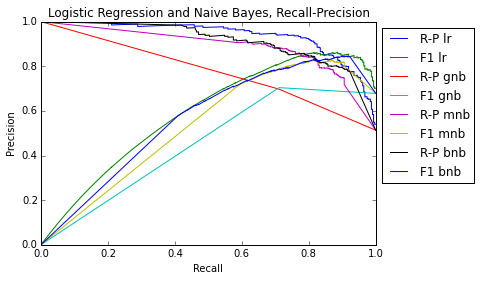

Logistic Regression ( lr ) AUC =  0.931306706992
Logistic Regression ( gnb ) AUC =  0.692848247643
Logistic Regression ( mnb ) AUC =  0.869935287315
Logistic Regression ( bnb ) AUC =  0.896409669098


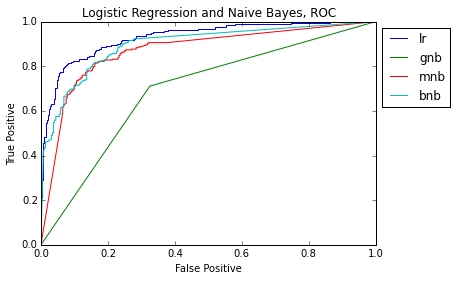

In [33]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
gnb.fit(X_train, Y_train)
gnb_predicted = gnb.predict_proba(X_test)
mnb.fit(X_train, Y_train)
mnb_predicted = mnb.predict_proba(X_test)
bnb.fit(X_train, Y_train)
bnb_predicted = bnb.predict_proba(X_test)

rp_curve('Logistic Regression and Naive Bayes, Recall-Precision', Y_test, logreg_1_predicted, label='lr')
rp_curve('Logistic Regression and Naive Bayes, Recall-Precision', Y_test, gnb_predicted, label='gnb')
rp_curve('Logistic Regression and Naive Bayes, Recall-Precision', Y_test, mnb_predicted, label='mnb')
rp_curve('Logistic Regression and Naive Bayes, Recall-Precision', Y_test, bnb_predicted, label='bnb')

plot.show()

roc_curve('Logistic Regression and Naive Bayes, ROC', Y_test, logreg_1_predicted, label='lr')
roc_curve('Logistic Regression and Naive Bayes, ROC', Y_test, gnb_predicted, label='gnb')
roc_curve('Logistic Regression and Naive Bayes, ROC', Y_test, mnb_predicted, label='mnb')
roc_curve('Logistic Regression and Naive Bayes, ROC', Y_test, bnb_predicted, label='bnb')

In [92]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid={
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'penalty': ['l1', 'l2']
    }, 
    scoring='roc_auc', cv=20, n_jobs=8).fit(X_train, Y_train)

In [94]:
def report_cross_validation(grid_searcher, X_test, Y_test):
    print 'train score is {:.5f}'.format(grid_searcher.best_score_)
    print 'test score is {:.5f}'.format(grid_searcher.score(X_test, Y_test))
    print 'best parameter set:'
    for k in sorted(grid_searcher.best_params_):
        print ' * {}={}'.format(k, grid_searcher.best_params_[k])

In [95]:
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.92934
test score is 1.00000
best parameter set:
 * C=1000
 * penalty=l1


###AdaBoost для RandomForest

In [62]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
n_estimators_rf = 450

random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators_rf)
random_forest_classifier.fit(X_train, Y_train)
predicted_random_forest = random_forest_classifier.predict_proba(X_test)

adaboost_classyfier = AdaBoostClassifier(RandomForestClassifier(n_estimators=n_estimators_rf), n_estimators=10)
adaboost_classyfier.fit(X_train, Y_train)
predicted_adaboost = adaboost_classyfier.predict_proba(X_test)

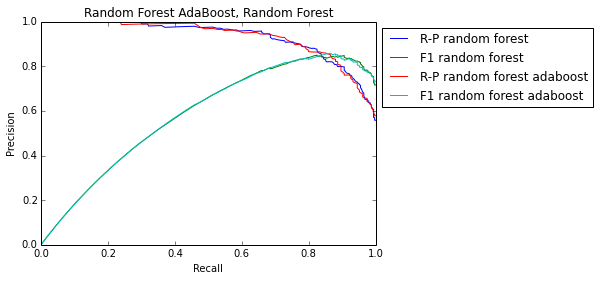

In [63]:
rp_curve('Random Forest AdaBoost, Random Forest', Y_test, predicted_random_forest, label='random forest')
rp_curve('Random Forest AdaBoost, Random Forest', Y_test, predicted_adaboost, label='random forest adaboost')

Logistic Regression ( random forest ) AUC =  0.92190001779
Logistic Regression ( random forest adaboost ) AUC =  0.922111279132


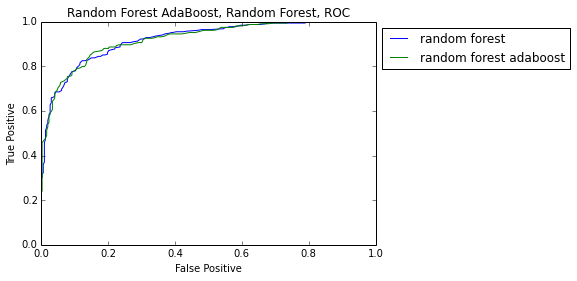

In [64]:
roc_curve('Random Forest AdaBoost, Random Forest, ROC', Y_test, predicted_random_forest, label='random forest')
roc_curve('Random Forest AdaBoost, Random Forest, ROC', Y_test, predicted_adaboost, label='random forest adaboost')

###AdaBoost для LogisticRegression

In [56]:
from sklearn.ensemble import AdaBoostRegressor

logreg_regressor_adaboost = AdaBoostRegressor(LogisticRegression(), n_estimators=30)
logreg_regressor_adaboost.fit(X_train, Y_train)
predicted_logreg_adaboost = logreg_regressor_adaboost.predict(X_test)

logreg_regressor =LogisticRegression()
logreg_regressor.fit(X_train, Y_train)
predicted_logreg = logreg_regressor.predict(X_test)

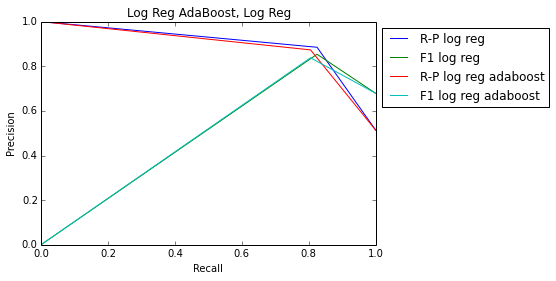

In [57]:
rp_no_proba_curve('Log Reg AdaBoost, Log Reg', Y_test, predicted_logreg, label='log reg')
rp_no_proba_curve('Log Reg AdaBoost, Log Reg', Y_test, predicted_logreg_adaboost, label='log reg adaboost')

Logistic Regression ( log reg ) AUC =  0.855830813023
Logistic Regression ( log reg adaboost ) AUC =  0.840953566981


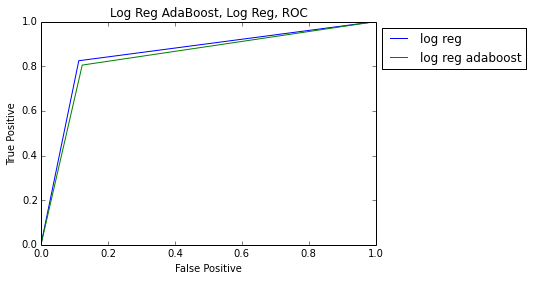

In [58]:
roc_no_proba_curve('Log Reg AdaBoost, Log Reg, ROC', Y_test, predicted_logreg, label='log reg')
roc_no_proba_curve('Log Reg AdaBoost, Log Reg, ROC', Y_test, predicted_logreg_adaboost, label='log reg adaboost')

### Матрицы частотности и встречаемости для биграм

In [67]:
count_vect = CountVectorizer(ngram_range=(2, 2), max_features=100000)
matrix_counts_bigram = count_vect.fit_transform(all_texts).toarray()

### Матрицы частотности и встречаемости для триграм

In [71]:
count_vect = CountVectorizer(ngram_range=(3, 3), max_features=100000)
matrix_counts_trigram = count_vect.fit_transform(all_texts).toarray()

### Сравнение логистической регрессии обычной и с биграмами

In [68]:
X_train_bigram, X_test_bigram, Y_train_bigram, Y_test_bigram = cross_valid(matrix_counts_bigram, target)
X_train_bigram, X_test_bigram = get_after_rf_matrix(X_train_bigram, Y_train_bigram, 50000, X_test_bigram)
logreg_bigram_predicted, _ = logistic_reg(X_train_bigram, X_test_bigram, Y_train_bigram)

In [72]:
X_train_trigram, X_test_trigram, Y_train_trigram, Y_test_trigram = cross_valid(matrix_counts_trigram, target)
X_train_trigram, X_test_trigram = get_after_rf_matrix(X_train_trigram, Y_train_trigram, 50000, X_test_trigram)
logreg_trigram_predicted, _ = logistic_reg(X_train_trigram, X_test_trigram, Y_train_trigram)

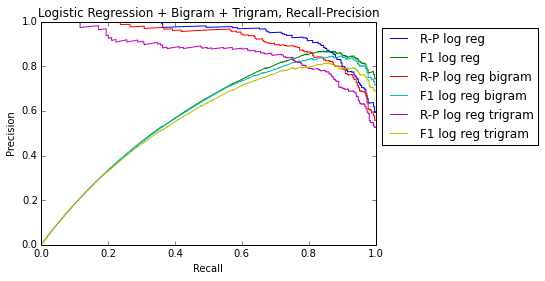

In [73]:
rp_curve('Logistic Regression + Bigram + Trigram, Recall-Precision', Y_test, logreg_counts_l1_predicted, label='log reg')
rp_curve('Logistic Regression + Bigram + Trigram, Recall-Precision', Y_test_bigram, logreg_bigram_predicted, label='log reg bigram')
rp_curve('Logistic Regression + Bigram + Trigram, Recall-Precision', Y_test_trigram, logreg_trigram_predicted, label='log reg trigram')

Logistic Regression ( log reg ) AUC =  0.935520814802
Logistic Regression ( log reg bigram ) AUC =  0.913805372709
Logistic Regression ( log reg trigram ) AUC =  0.865004002846


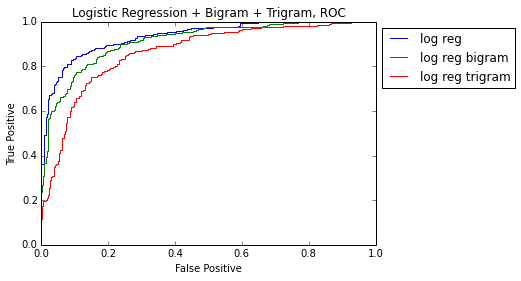

In [74]:
roc_curve('Logistic Regression + Bigram + Trigram, ROC', Y_test, logreg_counts_l1_predicted, label='log reg')
roc_curve('Logistic Regression + Bigram + Trigram, ROC', Y_test_bigram, logreg_bigram_predicted, label='log reg bigram')
roc_curve('Logistic Regression + Bigram + Trigram, ROC', Y_test_trigram, logreg_trigram_predicted, label='log reg trigram')